In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

In [127]:
X = torch.tensor([
    [1,2,3,4]
], dtype=torch.float32).T

Y = torch.tensor([1,4,9,16], dtype=torch.float32).unsqueeze(1)
print(X.shape, Y.shape)

torch.Size([4, 1]) torch.Size([4, 1])


In [128]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [129]:
module = NN()
optimizer = Adam(module.parameters(), lr=0.1)
criterion = nn.MSELoss()

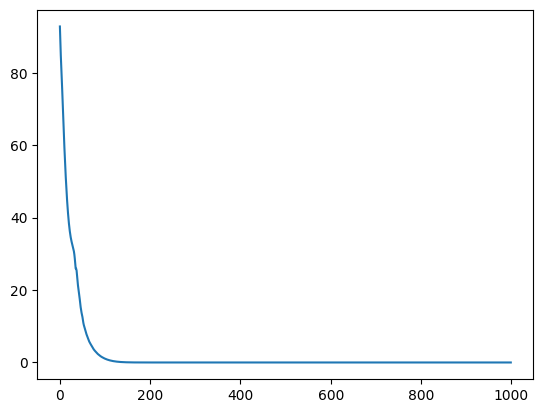

In [130]:
epochs = 1000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = module(X)
    loss = criterion(output, Y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.show()
    

In [131]:
# Test
with torch.no_grad():
    output = module(X)
    print(torch.round(output))

tensor([[ 1.],
        [ 4.],
        [ 9.],
        [16.]])


In [2]:
from IPython.display import clear_output
from collections import deque
import random, numpy as np
from tqdm import trange
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode="rgb_array")
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [14]:
# Utils
def show_env(img):
    plt.imshow(img)
    plt.axis('off')
    clear_output(wait=True)
    plt.show()

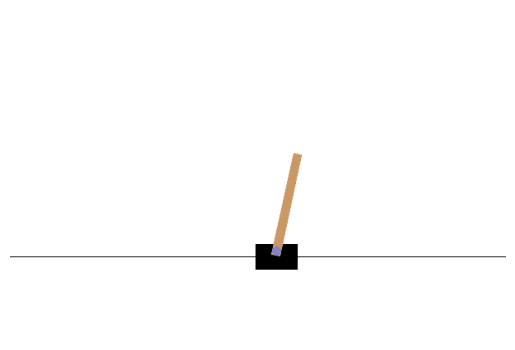

In [15]:
s, _ = env.reset()
done = False

while not done:
    a = env.action_space.sample()
    s, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated
    show_env(env.render())
    

In [5]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
class Agent:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        
        self.env = gym.make('CartPole-v1', render_mode="rgb_array")
        
        self.memory = deque(maxlen=10_000)
        self.gamma = 0.99
        self.e = 1.0
        self.e_min = 0.01
        self.e_decay = 1000
        self.learning_rate = 0.001
        self.batch_size = 64
        
        self.local = DQN(self.env.observation_space.shape[0], self.env.action_space.n).to(self.device)
        self.target = DQN(self.env.observation_space.shape[0], self.env.action_space.n).to(self.device)
        self.target.load_state_dict(self.local.state_dict())
        self.target.eval()
        
        self.optimizer = Adam(self.local.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def act(self, s):
        if np.random.rand() > self.e:
            with torch.no_grad():
                s = torch.tensor(s, dtype=torch.float32).to(self.device)
                return torch.argmax(self.local(s)).item()
        else:
            return self.env.action_space.sample()
        
    def train(self, epochs):
        loss = None
        pbar = trange(epochs, desc="reward_mean: 0.0")
        rewards_plot = []
        rewards_list = deque(maxlen=100)
        for epoch in range(1, epochs):
            self.e = np.clip(1.0-np.log10(epoch/self.e_decay), self.e_min, 1.0)
            s, _ = self.env.reset()
            done = False
            total_reward = 0
            
            while not done:
                a = self.act(s)
                sp, r, terminated, truncated, _ = self.env.step(a)
                done = terminated or truncated
                self.memory.append((s, a, r, sp, done))
                s = sp
                total_reward+=r
            
            rewards_list.append(total_reward)
            rewards_plot.append(np.mean(rewards_list))
                
            if len(self.memory) >= self.batch_size:
                batch = random.sample(self.memory, self.batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                states, rewards, next_states = [torch.tensor(np.array(x), dtype=torch.float32).to(self.device) for x in (states, rewards, next_states)]
                actions, dones = [torch.tensor(np.array(x), dtype=torch.long).to(self.device) for x in (actions, dones)]
                
                current_q_values = self.local(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = self.target(next_states).max(1)[0]
                target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
                
                loss =self.criterion(current_q_values, target_q_values)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                    
            if epoch % 10 == 0 and len(self.memory) >= self.batch_size:
                self.target.load_state_dict(self.local.state_dict())
                pbar.set_description(f"reward_mean: {np.mean(total_reward)}")
            pbar.update(1)
        pbar.close()
        plt.plot(rewards_plot)

In [16]:
agent = Agent()
agent.train(10000)

cuda


reward_mean: 0.0:   0%|          | 0/10000 [00:00<?, ?it/s]

reward_mean: 32.0:   8%|▊         | 765/10000 [00:01<00:20, 452.05it/s]

KeyboardInterrupt: 

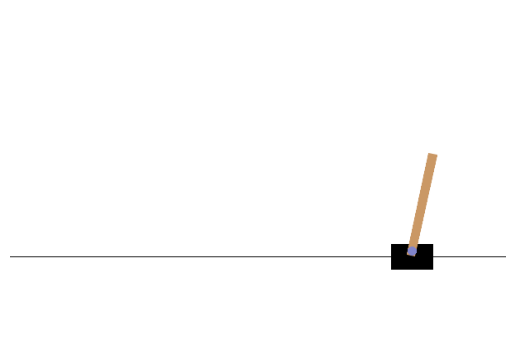

151.0


reward_mean: 32.0:   8%|▊         | 765/10000 [00:21<00:20, 452.05it/s]

In [17]:
# Test
s, _ = agent.env.reset()
done = False
total_reward = 0
while not done:
    agent.e = 0.0
    a = agent.act(s)
    s, r, terminated, truncated, _ = agent.env.step(a)
    done = terminated or truncated
    show_env(agent.env.render())
    total_reward+=r
print(total_reward)
agent.env.close()
    